In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import warnings
# importing os module 
import os
# Imports PIL module 
from keras.models import Model
from PIL import Image # for grabbing images
from itertools import chain #for target labels 
from keras.utils import np_utils
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from pathlib import Path
import seaborn as sns
import pandas as pd
import tensorflow
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
warnings.filterwarnings("ignore")
from tensorflow.keras.applications.vgg16 import preprocess_input

In [2]:
rm -rf `find -type d -name .ipynb_checkpoints`

## Get Training and Test Samples as NumPy Arrays

In [3]:
X_train=np.load("train_data.npy");
t_train=np.load("train_label.npy");
print(t_train.shape)
num_of_output_classes=len(np.unique(t_train))
X_train=tensorflow.keras.applications.vgg16.preprocess_input(X_train, data_format=None);

(3360,)


## Training on all images

In [4]:
def train_transfer_learning_CNN(num_of_classes,data_train, labels_train, img_size=214, epochs=5, learning_rate=1e-4):
    
    # load data and labels
    #data_train = np.load(data_train_path)
    #labels_train_temp = np.load(labels_train_path)
    
    # preprocessing
    #gray_scaled=Invert_gray_scale(data_train,300) #Converts all 300x300 images to grey scale
    
    #dilated_data=Dilation(gray_scaled,300) # Dilates all 300x300 images
    
    #bkg_removed_matrix=Remove_bkg_noise(dilated_data,300) #Removes background from 300x300 images
    
    #resized_matrix=resize(bkg_removed_matrix,img_size) #Resizes to img_size x img_size
 
    # Normalize data
    labels_train = np_utils.to_categorical(labels_train, num_of_classes)
    
    # specify a new input shape to replace VGG16 input layer for our data
    new_input = (img_size, img_size, 3)
    
    # load model
    model = VGG16(include_top=False, input_shape=new_input, pooling='max')
    
    #remove output layer to replace with new one to allow for classification of the 3 classes instead of the original VGG16
    # classification 
    flat1 = Flatten()(model.layers[-1].output) # remove output layer
    class1 = Dense(1024, activation='relu')(flat1) # new dense layer
    output = Dense(num_of_classes, activation='softmax')(class1) # for 3 classes
    
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    
    # print summary of model
    model.summary()

    # set Adam learning rate
    adam = Adam(lr=learning_rate)

    # We add metrics to get more results you want to see
    model.compile(optimizer=adam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # fit model
    print('Training ------------')
    history = model.fit(X_train,labels_train, epochs=epochs)
                
    # plot training accuracy
    plt.plot(history.history['accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['Training'], loc='upper left')
    plt.show()

    # save trained VGG16 CNN model
    model.save('vgg16_trained_cnn.hdf5')

2023-03-29 20:59:19.299054: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-29 20:59:19.824930: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79111 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:90:00.0, compute capability: 8.0


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

2023-03-29 20:59:22.616446: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2023-03-29 20:59:23.486739: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Running ptxas --version returned 32512
2023-03-29 20:59:23.573178: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-03-29 20:59:24.621511: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


105/105 [==============================] - 6s 15ms/step - loss: 1.3300 - accuracy: 0.6345
Epoch 2/5
105/105 [==============================] - 2s 15ms/step - loss: 0.3295 - accuracy: 0.8958
Epoch 3/5
105/105 [==============================] - 2s 15ms/step - loss: 0.2177 - accuracy: 0.9318
Epoch 4/5
105/105 [==============================] - 2s 15ms/step - loss: 0.1664 - accuracy: 0.9461
Epoch 5/5
105/105 [==============================] - 2s 15ms/step - loss: 0.0994 - accuracy: 0.9682


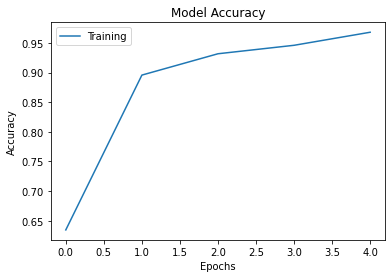

In [5]:
# train VGG16 CNN
train_transfer_learning_CNN(num_of_output_classes,X_train,t_train, img_size=100, epochs=5, learning_rate=1e-4)

## Training performance when randomly pulling out 20% of the data

per_keep=.8 #keep 80% of data
X_train_rand=X_train[0:int(per_keep*X_train.shape[0]),:,:,:]
t_train_rand=t_train[0:int(per_keep*t_train.shape[0])]
print("New Training shape")
print(t_train_rand.shape)
print(X_train_rand.shape)

train_transfer_learning_CNN(num_of_output_classes,X_train_rand,t_train_rand, img_size=214, epochs=5, learning_rate=1e-4)